# AutoEncoder model 

### Loading the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np

In [165]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

### Define the constants

In [7]:
DATA_SLICE_SIZE = 100
ANOMALY_INJECTION_SAMPLE_SIZE = 4000

In [2]:
def multiple_plotting(path_list):
    n_paths = len(path_list)
    data_df_list = []

    if n_paths == 0:
        print("Insert the correct paths!")

    # let last column vacant if the # of paths are odd
    vacant_col = n_paths % 2 != 0

    for path in path_list:
        data_df = pd.read_csv(path, header=None)
        data_df.columns = ['x', 'y', 'z']
        data_df_list.append(data_df)


    #################### Do not touch the logic
    n_rows = n_paths // 2
    if vacant_col:
        n_rows += 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(8, 2 * n_rows))


    for ax in axes.flatten():
        ax.set_ylim(0.6, 1.4)

    cur_df = 0

    # For edge case: only for one or two path list
    if n_paths <= 2:
        if not vacant_col:
            vector_value_2 = np.sqrt(data_df_list[1]['x']**2 + data_df_list[1]['y']**2 + data_df_list[1]['z']**2)
            axes[1].plot(vector_value_2)
        vector_value_1 = np.sqrt(data_df_list[0]['x']**2 + data_df_list[0]['y']**2 + data_df_list[0]['z']**2)
        axes[0].plot(vector_value_1)
        return

    # For Normal case: more than two path list
    for i in range(n_rows):
        for j in range(2):
            # Check whether last col should be vacant or not
            if i == n_paths // 2 and j == 1 and vacant_col:
                axes[i, j].axis('off')
                continue
            ##
            vector_value = np.sqrt(data_df_list[cur_df]['x']**2 + data_df_list[cur_df]['y']**2 + data_df_list[cur_df]['z']**2)
            axes[i, j].plot(vector_value)

            cur_df += 1
    ####################

    plt.show()

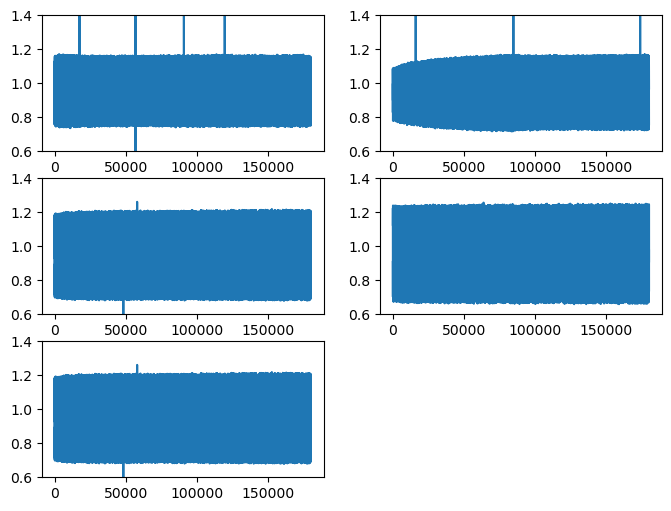

In [3]:
# Insert data paths in one list
multiple_plotting(['data/normal_9v_data.csv', 'data/normal_10v_data.csv',
                   'data/normal_11v_data.csv', 'data/normal_12v_data.csv',
                   'data/normal_11v_data.csv',])

In [8]:
import glob
file_paths = glob.glob('./data/anomaly_data/*.csv')

df_list = []

for file in file_paths:
    data_df = pd.read_csv(file, header=None)

    data_df = data_df[:ANOMALY_INJECTION_SAMPLE_SIZE]
    df_list.append(data_df)

anomaly_df = pd.concat(df_list, ignore_index=True)
anomaly_df.columns = ['x', 'y', 'z']

In [9]:
anomaly_df.shape

(40000, 3)

### Add normal datasets

In [4]:
data_normal_9v_df = pd.read_csv('data/normal_9v_data.csv', header=None)
data_normal_10v_df = pd.read_csv('data/normal_10v_data.csv', header=None)
data_normal_11v_df = pd.read_csv('data/normal_11v_data.csv', header=None)
data_normal_12v_df = pd.read_csv('data/normal_12v_data.csv', header=None)
data_normal_9v_common_noise_df = pd.read_csv('./data/normal_9v_common_noise_data.csv', header=None)
data_normal_9v_vibration_noise_df = pd.read_csv('./data/normal_9v_vibration_noise_data.csv', header=None)

# data_normal_9v_df = scaler.fit_transform(data_normal_9v_df)
# data_normal_10v_df = scaler.fit_transform(data_normal_10v_df)
# data_normal_11v_df = scaler.fit_transform(data_normal_11v_df)
# data_normal_12v_df = scaler.fit_transform(data_normal_12v_df)
# data_normal_9v_common_noise_df = scaler.fit_transform(data_normal_9v_common_noise_df)
# data_normal_9v_vibration_noise_df = scaler.fit_transform(data_normal_9v_vibration_noise_df)

combined_df = pd.concat([data_normal_9v_df, data_normal_10v_df,
                          data_normal_11v_df, data_normal_12v_df,
                          data_normal_9v_common_noise_df, data_normal_9v_vibration_noise_df], ignore_index=True)
print(combined_df.shape)

(960578, 3)


### Split data

In [113]:
import glob
train_ratio = 0.7
temp_ratio = 0.3  # for both val and test combined
val_ratio = 0.5  # 50% of temp_ratio for validation
test_ratio = temp_ratio / 2  # same as val_ratio

data_normal_12v_df = data_normal_12v_df[:len(data_normal_12v_df) - (len(data_normal_12v_df) % DATA_SLICE_SIZE)]
data_normal_9v_vibration_noise_df = data_normal_9v_vibration_noise_df[:len(data_normal_9v_vibration_noise_df) - (len(data_normal_9v_vibration_noise_df)% DATA_SLICE_SIZE)]
# print(len(data_normal_9v_df), len(data_normal_10v_df), len(data_normal_11v_df), len(data_normal_12v_df))
# print(data_normal_9v_df.shape, data_normal_10v_df.shape, data_normal_11v_df.shape, data_normal_12v_df.shape)

# print(data_normal_9v_df.shape)
# print(data_normal_10v_df.shape)
# print(data_normal_11v_df.shape)
# print(data_normal_12v_df.shape)
# print(data_normal_9v_common_noise_df.shape)
# print(data_normal_9v_vibration_noise_df.shape)


data_normal_9v_split = np.array_split(data_normal_9v_df, len(data_normal_9v_df) // DATA_SLICE_SIZE)
data_normal_10v_split = np.array_split(data_normal_10v_df, len(data_normal_10v_df) // DATA_SLICE_SIZE)
data_normal_11v_split = np.array_split(data_normal_11v_df, len(data_normal_11v_df) // DATA_SLICE_SIZE)
data_normal_12v_split = np.array_split(data_normal_12v_df, len(data_normal_12v_df) // DATA_SLICE_SIZE)
data_normal_9v_common_noise_split = np.array_split(data_normal_9v_common_noise_df, len(data_normal_9v_common_noise_df) // DATA_SLICE_SIZE)
data_normal_9v_vibration_noise_split = np.array_split(data_normal_9v_vibration_noise_df, len(data_normal_9v_common_noise_df) // DATA_SLICE_SIZE)


anomaly_file_paths = glob.glob('./data/anomaly_data/*.csv')

anomaly_splits = []
anomaly_splits_test = []
for i in anomaly_file_paths:
    data_df = pd.read_csv(file, header=None)
    # print(data_df.shape)
    data_df_quarter = data_df.iloc[:len(data_df) // 10] 
    data_df_split = np.array_split(data_df_quarter, len(data_df_quarter) // DATA_SLICE_SIZE)

    data_df_quarter_test = data_df.iloc[len(data_df) // 10:] 
    data_df_split_test = np.array_split(data_df_quarter_test, len(data_df_quarter_test) // DATA_SLICE_SIZE)

    anomaly_splits_test.append(data_df_split_test)
    anomaly_splits.append(data_df_split)
    # print(y_label_1_.shape)
    # print("aaa", len(data_df_split))

# print("anomaly shape ", anomaly_splits.shape)

data_splits = [data_normal_9v_split, data_normal_10v_split,
                data_normal_11v_split, data_normal_11v_split,
                data_normal_9v_common_noise_split,
                data_normal_9v_vibration_noise_split]

y_label_0_raw = []
y_label_1_raw = []
y_label_1_raw_test = []

for i in data_splits:
    print(len(i))
    y_label_0 = np.zeros(len(i))
    y_label_0_raw.append(y_label_0)

for i in anomaly_splits:
    # print(i.shape)
    y_label_1 = np.ones(len(i))
    y_label_1_raw.append(y_label_1)

for i in anomaly_splits_test:
    # print(i.shape)
    y_label_1_test = np.ones(len(i))
    y_label_1_raw_test.append(y_label_1_test)

anomaly_splits_test_raw = np.concatenate(anomaly_splits_test, axis = 0)


y_label_0_raw = np.concatenate(y_label_0_raw, axis=0)
y_label_1_raw = np.concatenate(y_label_1_raw, axis=0)
y_label_1_raw_test = np.concatenate(y_label_1_raw_test, axis=0)
print(len(y_label_0_raw), len(y_label_1_raw), len(y_label_1_raw_test))



y_label_raw = np.concatenate((y_label_0_raw, y_label_1_raw), axis = 0)
print(y_label_raw.shape)
data_splits.extend(anomaly_splits)
# print(len(anomaly_splits), len(data_splits))

train_sizes = []
train_data = []
val_data = []
test_data = []

y_train_data = []
y_val_data = []
y_test_data = []
start_idx = 0

for i in range(len(data_splits)):
    data_len = len(data_splits[i])
    train_size = int(data_len * train_ratio)
    temp_size = data_len - train_size 
    val_size = int(temp_size * val_ratio)
    
    # Split the data
    train_sizes.append(train_size)
    train_data.append(data_splits[i][:train_size])
    val_data.append(data_splits[i][train_size:train_size + val_size])
    test_data.append(data_splits[i][train_size + val_size:])

    y_train_data.append(y_label_raw[start_idx:start_idx + train_size])
    y_val_data.append(y_label_raw[start_idx + train_size:start_idx + train_size + val_size])
    y_test_data.append(y_label_raw[start_idx + train_size + val_size:start_idx + data_len])

    start_idx += data_len



# print("ddd", len(train_data[-1][-1]), len(val_data[-1][-1]),  len(test_data[-1][-1]))

# check the lengths of each split
for i in range(len(data_splits)):
    print(f"Data split {i}: train + val + test =", len(train_data[i]), "+", len(val_data[i]), "+", len(test_data[i]))
    print(len(train_data[i][0]), len(val_data[i][0]),  len(test_data[i][0]))

# Concatenate all splits across the normal datasets
x_train_concat = np.concatenate(train_data, axis=0)
x_val_concat = np.concatenate(val_data, axis=0)
x_test_concat = np.concatenate(test_data, axis=0)

y_train_concat = np.concatenate(y_train_data, axis=0)
y_val_concat = np.concatenate(y_val_data, axis=0)
y_test_concat = np.concatenate(y_test_data, axis=0)

# Output shapes to assure correct shape
print("Train data shape:", x_train_concat.shape)
print("Validation data shape:", x_val_concat.shape)
print("Test data shape:", x_test_concat.shape)

print("Train data shape:", y_train_concat.shape)
print("Validation data shape:", y_val_concat.shape)
print("Test data shape:", y_test_concat.shape)


print("anomaly_splits_test_raw.shape ", anomaly_splits_test_raw.shape, y_label_1_raw_test.shape)



/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future v

1800
1800
1800
1800
1200
1200
9600 1800 16200
(11400,)
Data split 0: train + val + test = 1260 + 270 + 270
100 100 100
Data split 1: train + val + test = 1260 + 270 + 270
100 100 100
Data split 2: train + val + test = 1260 + 270 + 270
100 100 100
Data split 3: train + val + test = 1260 + 270 + 270
100 100 100
Data split 4: train + val + test = 840 + 180 + 180
100 100 100
Data split 5: train + val + test = 840 + 180 + 180
100 100 100
Data split 6: train + val + test = 125 + 27 + 28
100 100 100
Data split 7: train + val + test = 125 + 27 + 28
100 100 100
Data split 8: train + val + test = 125 + 27 + 28
100 100 100
Data split 9: train + val + test = 125 + 27 + 28
100 100 100
Data split 10: train + val + test = 125 + 27 + 28
100 100 100
Data split 11: train + val + test = 125 + 27 + 28
100 100 100
Data split 12: train + val + test = 125 + 27 + 28
100 100 100
Data split 13: train + val + test = 125 + 27 + 28
100 100 100
Data split 14: train + val + test = 125 + 27 + 28
100 100 100
Data spli

In [115]:
from keras.utils import to_categorical

# Convert y_train and y_valid to one-hot encoding
y_train_one_hot = to_categorical(y_train_concat, num_classes=2)  # Assuming classes are 0, 1
y_valid_one_hot = to_categorical(y_val_concat, num_classes=2)  # Assuming you have a similar y_valid
y_test_one_hot = to_categorical(y_test_concat, num_classes=2)  # Assuming you have a similar y_test

# Check the shape
print(y_train_one_hot.shape)  # Should be (10070, 4)
print(y_valid_one_hot.shape) 
print(y_test_one_hot.shape) 

(7970, 2)
(1710, 2)
(1720, 2)


In [116]:
# Sum along axis 0 to get the count of each class
class_counts = np.sum(y_train_one_hot, axis=0)

# Calculate the percentage of each class
class_ratios = class_counts / np.sum(class_counts)

# Print the results
for i, (count, ratio) in enumerate(zip(class_counts, class_ratios)):
    print(f"Class {i}: count = {int(count)}, ratio = {ratio:.2%}")

Class 0: count = 6720, ratio = 84.32%
Class 1: count = 1250, ratio = 15.68%


In [117]:
import tensorflow as tf
import keras
from keras.layers import LSTM, Dropout, Dense, InputLayer
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [118]:
model = keras.models.Sequential([
    # Conv Block 1 
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu",
                        input_shape=[100, 3]),
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"), 

    # Pooling layer
    keras.layers.MaxPooling1D(pool_size=2),

    # Conv Block 2 
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),           
    
    # Pooling layer
    keras.layers.MaxPooling1D(pool_size=2),  

    # Conv Block 3
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),   
    
    # Pooling layer        
    keras.layers.MaxPooling1D(pool_size=2),  

    # Conv Block 4
    # keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),

    keras.layers.GlobalAveragePooling1D(),

    # Updated output layer for multi-class classification
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")  
])

# Compile the model
model.compile(loss="binary_crossentropy",  # Use categorical crossentropy
              optimizer="adam",
              metrics=["accuracy"])  # Accuracy metric is still appropriate

# # Train the model
# history = model.fit(
#     x_train_concat, y_train_one_hot,  # Ensure y_train is one-hot encoded for multi-class
#     epochs=20,  
#     batch_size=32,
#     validation_data=(x_val_concat, y_valid_one_hot),
#     verbose=1,
#     # class_weight=class_weights_dict,
#     # callbacks=[early_stop]
# )

# # Get predictions
# y_pred = model.predict(x_test_concat)
# y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Train the model
history = model.fit(
    x_train_concat, y_train_concat,  # Ensure y_train is one-hot encoded for multi-class
    epochs=10,  
    batch_size=32,
    validation_data=(x_val_concat, y_val_concat),
    verbose=1,
    # class_weight=class_weights_dict,
    # callbacks=[early_stop]
)

# Get predictions
y_pred = model.predict(x_test_concat)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# # Save the model
model.save("conv_net_new_data_anomaly_15p.h5")


Epoch 1/10


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9027 - loss: 0.2848 - val_accuracy: 1.0000 - val_loss: 4.0835e-06
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 1.9676e-06 - val_accuracy: 1.0000 - val_loss: 1.0043e-07
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 5.5747e-07 - val_accuracy: 1.0000 - val_loss: 5.9234e-08
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 2.0568e-07 - val_accuracy: 1.0000 - val_loss: 3.5954e-08
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.0605e-07 - val_accuracy: 1.0000 - val_loss: 2.2186e-08
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 5.9005e-08 - val_accuracy: 1.0000 - val_loss: 1.3808e-08
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 3.3802e-08 - val_accuracy: 1.0000 - val_loss: 8.5572e-09
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy:

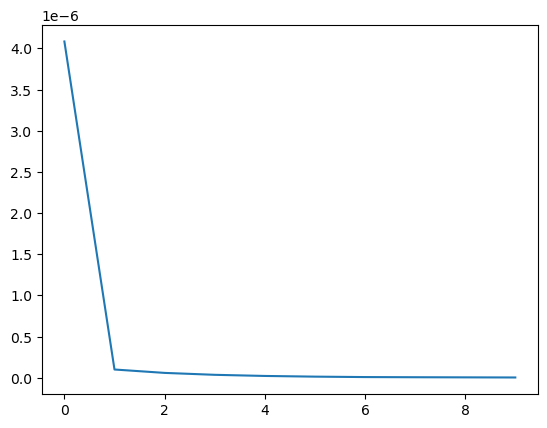

In [119]:

plt.plot(history.history["val_loss"])

In [120]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 100, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 25, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,829 (1.29 MB)

 Trainable params: 112,609 (439.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,220 (879.77 KB)

In [122]:
loss, accuracy = model.evaluate(x_test_concat, y_test_concat, verbose=1)
print(loss)
print(accuracy)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9173e-09
2.58273114006613e-09
1.0


In [121]:
loss, accuracy = model.evaluate(anomaly_splits_test_raw, y_label_1_raw_test, verbose=1)
print(loss)
print(accuracy)

507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.7225e-10
1.9371136639190212e-10
1.0


In [123]:
y_pred = model.predict(anomaly_splits_test_raw, verbose=1)

print(y_pred[:10])
print(y_label_1_raw_test[:10])

507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [124]:
y_pred = model.predict(x_test_concat, verbose=1)

print(y_pred[:10])
print(y_test_concat[:10])

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2.5087937e-11]
 [2.1172064e-11]
 [2.3268580e-11]
 [2.2358827e-11]
 [2.5224158e-11]
 [2.7434615e-11]
 [2.3517058e-11]
 [3.0206528e-11]
 [3.0113335e-11]
 [3.3964567e-11]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [72]:
import numpy as np

# y_pred의 형태 확인 및 정수형으로 변환
if y_pred.ndim == 2:
    y_pred = np.argmax(y_pred, axis=1)
elif y_pred.ndim == 1:
    print("y_pred는 이미 클래스 인덱스입니다.")

# y_test 및 y_pred의 고유 클래스 추출
unique_classes = np.unique(np.concatenate((y_test_concat, y_pred)))  # 두 배열의 고유 클래스 합치기

# 클래스 인덱스를 0부터 시작하도록 조정
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
y_test_mapped = np.array([class_to_index[cls] for cls in y_test_concat])
y_pred_mapped = np.array([class_to_index[cls] for cls in y_pred])


print(len(y_test_mapped))
print(len(y_pred_mapped))
# 혼동 행렬 초기화
num_classes = len(unique_classes)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# 혼동 행렬 계산
for i in range(len(y_test_concat)):
    conf_matrix[y_test_mapped[i], y_pred_mapped[i]] += 1

# 혼동 행렬 출력
print("혼동 행렬:\n", conf_matrix)

4140
4140
혼동 행렬:
 [[1440    0]
 [   0 2700]]


In [105]:
## v1 - 
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test_concat)

y_pred_labels = (y_pred > 0.5).astype(int)
# y_test_labels = np.argmax(y_test_concat, axis=1) 
print(y_pred_labels.shape, y_test_concat.shape)

print(classification_report(y_test_concat, y_pred_labels))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(2120, 1) (2120,)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1440
         1.0       1.00      1.00      1.00       680

    accuracy                           1.00      2120
   macro avg       1.00      1.00      1.00      2120
weighted avg       1.00      1.00      1.00      2120



### Add Anomaly datasets

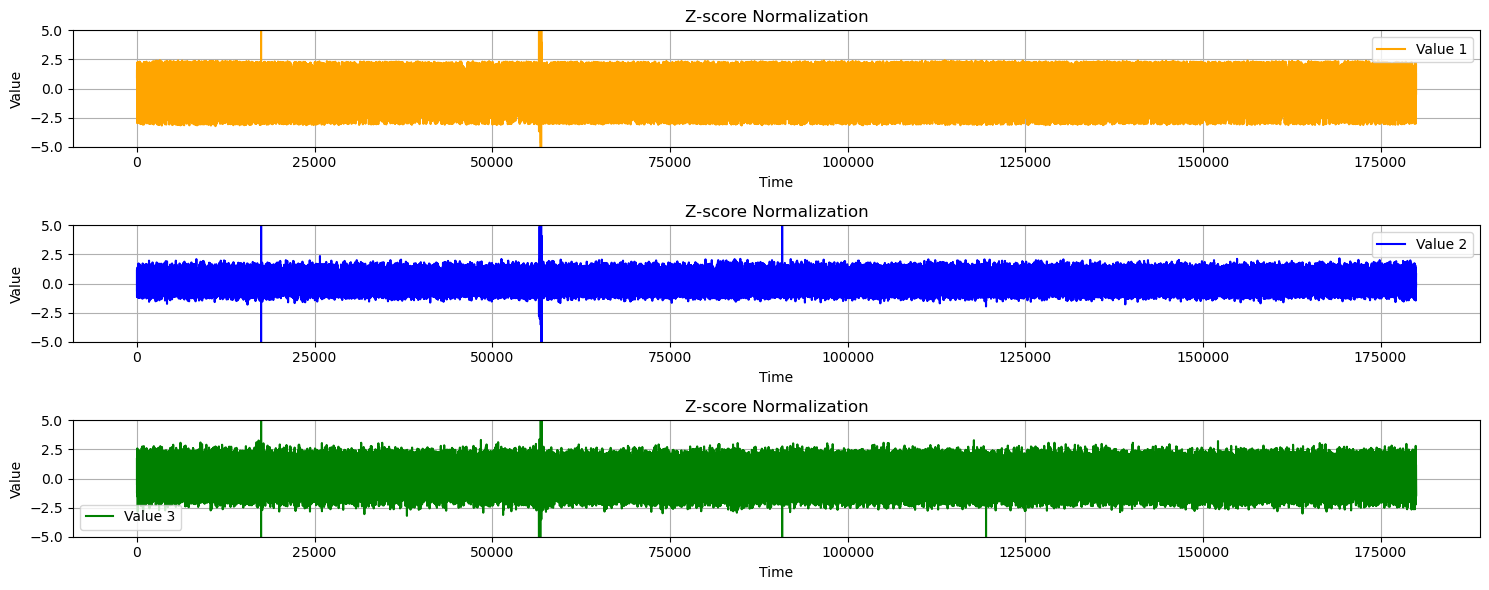

In [ ]:
# 시각화
time = np.arange(data1_df.shape[0])  
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1) 
plt.plot(time, data1_df[:, 0], color='orange', label='Value 1')
# plt.plot(time, data1_df[:, 1], color='blue', label='Value 2')
# plt.plot(time, data1_df[:, 2], color='green', label='Value 3')

plt.title('Z-score Normalization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-5, 5)
plt.grid()
plt.legend()


plt.subplot(3, 1, 2) 
# plt.plot(time, data1_df[:, 0], color='orange', label='Value 1')
plt.plot(time, data1_df[:, 1], color='blue', label='Value 2')
# plt.plot(time, data1_df[:, 2], color='green', label='Value 3')

plt.title('Z-score Normalization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-5, 5)
plt.grid()
plt.legend()


plt.subplot(3, 1, 3) 
# plt.plot(time, data1_df[:, 0], color='orange', label='Value 1')
# plt.plot(time, data1_df[:, 1], color='blue', label='Value 2')
plt.plot(time, data1_df[:, 2], color='green', label='Value 3')

plt.title('Z-score Normalization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-5, 5)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [188]:
# 모델 학습
autoencoder.fit(
    x_train_concat, 
    x_train_concat,
    epochs=20, 
    batch_size=32, 
    validation_data = (x_val_concat, x_val_concat),
    verbose = 1,
    shuffle=True
    # validation_split=0.2
    )


Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0315 - val_loss: 0.0044
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 11/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 12/20
158/158 ━━━━━━━━━━

In [134]:
autoencoder.save("autoencoder_1-lstm.h5")

### Check Anomaly data

In [102]:
anomaly_data1 = 'data/anomaly_data/anomaly_3v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_3v_data2.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_5v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_5v_data2.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

TypeError: multiple_plotting() takes 1 positional argument but 4 were given

<Figure size 2000x2000 with 0 Axes>

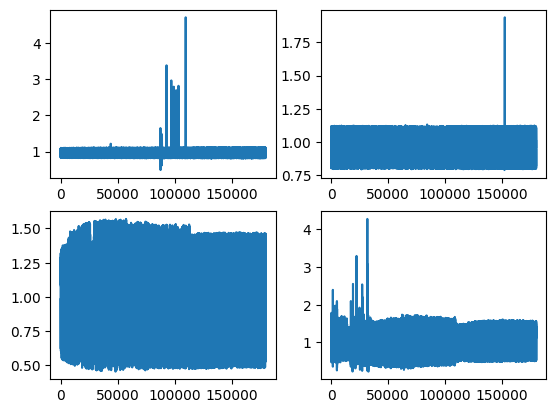

In [13]:
anomaly_data1 = 'data/anomaly_data/anomaly_7v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_7v_data2.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_contact_9v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_contact_12v_data1.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

<Figure size 2000x2000 with 0 Axes>

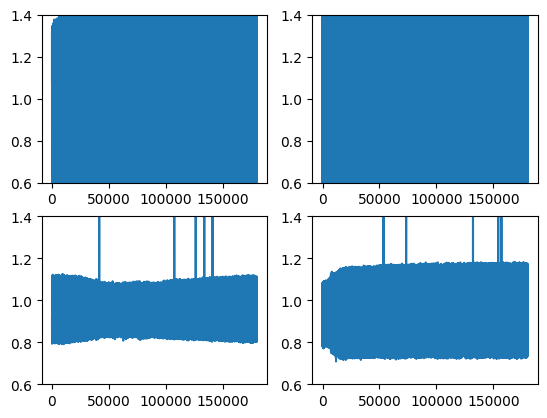

In [18]:

anomaly_data1 = 'data/anomaly_data/anomaly_contact_9v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_contact_12v_data1.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_unbalanced_9v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_unbalanced_12v_data1.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

### Anomaly dataset prepration

In [103]:
import os

folder_path = 'data/anomaly_data'

anomaly_data_path = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

print(anomaly_data_path)


['data/anomaly_data/anomaly_7v_data2.csv', 'data/anomaly_data/anomaly_7v_data1.csv', 'data/anomaly_data/anomaly_5v_data2.csv', 'data/anomaly_data/anomaly_5v_data1.csv', 'data/anomaly_data/anomaly_unbalanced_9v_data1.csv', 'data/anomaly_data/anomaly_3v_data1.csv', 'data/anomaly_data/anomaly_3v_data2.csv', 'data/anomaly_data/anomaly_unbalanced_12v_data1.csv', 'data/anomaly_data/anomaly_contact_12v_data1.csv', 'data/anomaly_data/anomaly_contact_9v_data1.csv']


### Test with just anomaly data

In [12]:
all_anomaly_test_data = []
for data in anomaly_data_path:
    df = pd.read_csv(data)
    df = df[:len(df) - (len(df) % 100)]
    all_anomaly_test_data.append(df.values.reshape(-1, 100, 3))
    # print(df.shape)

# all_anomaly_test_data = np.concatenate(all_anomaly_test_data, axis=0)
for i in range(len(all_anomaly_test_data)):
    print(all_anomaly_test_data[i].shape)


(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1799, 100, 3)
(1800, 100, 3)
(1799, 100, 3)
(1799, 100, 3)
(1800, 100, 3)
(1800, 100, 3)


In [4]:
import tensorflow as tf
print(tf.__version__)


2.3.0


In [111]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

autoencoder = load_model("autoencoder.h5")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


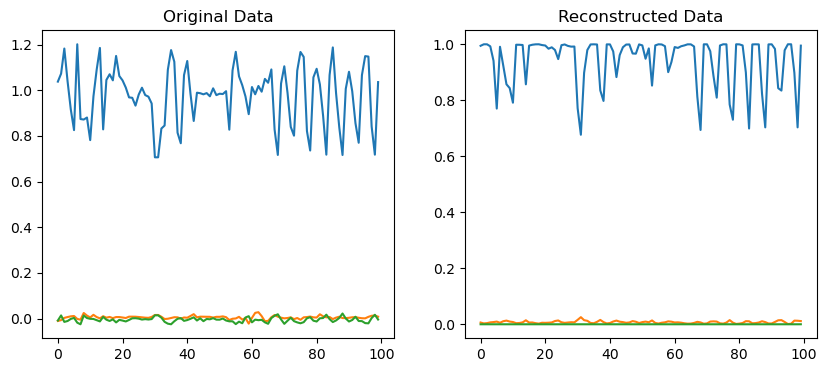

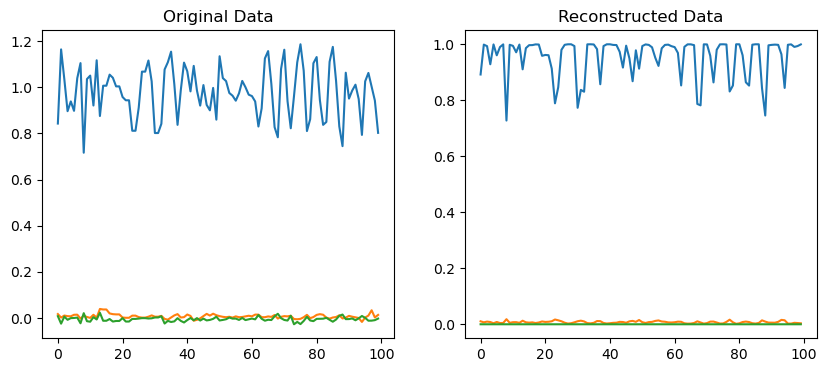

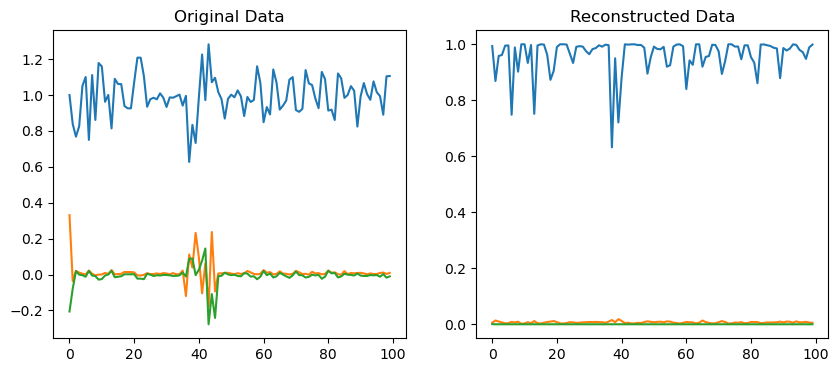

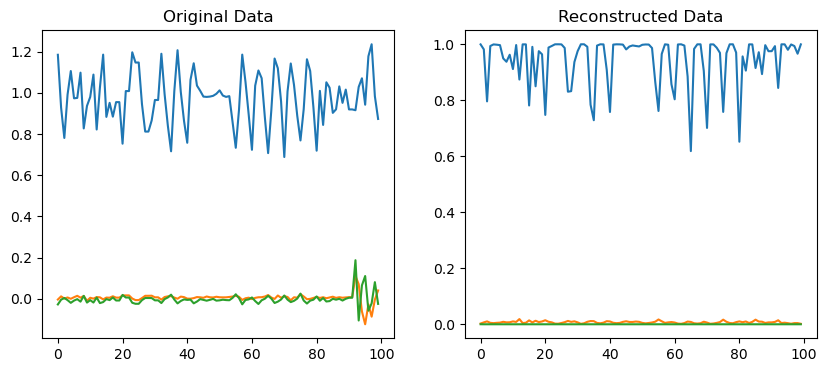

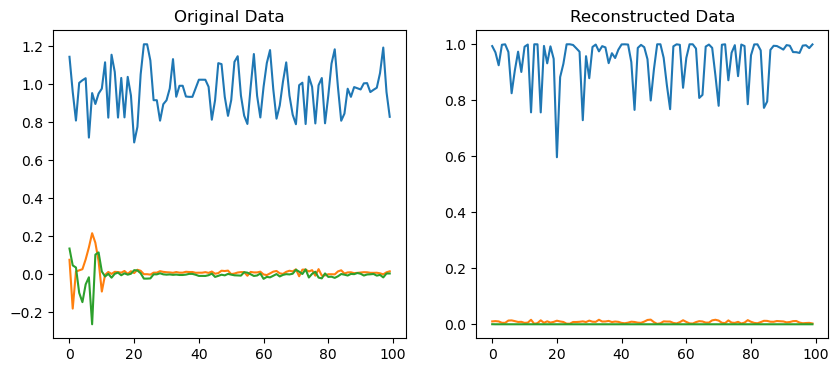

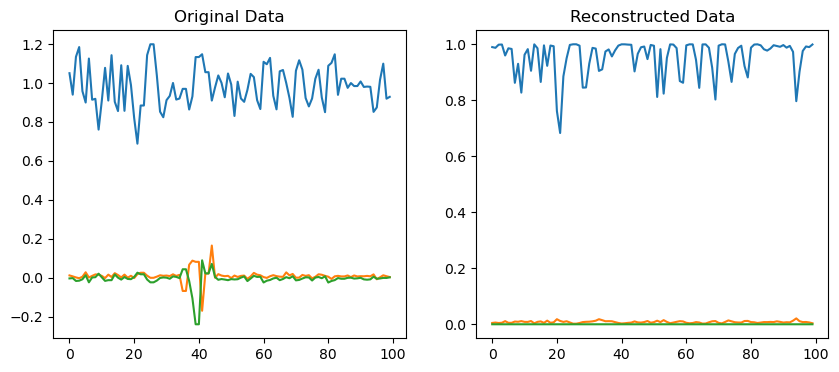

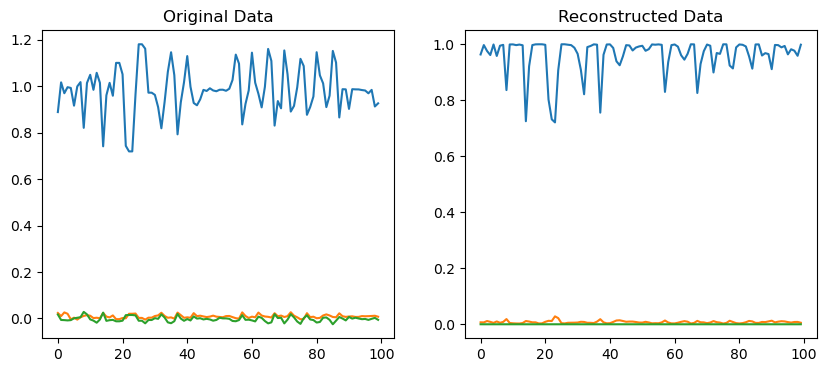

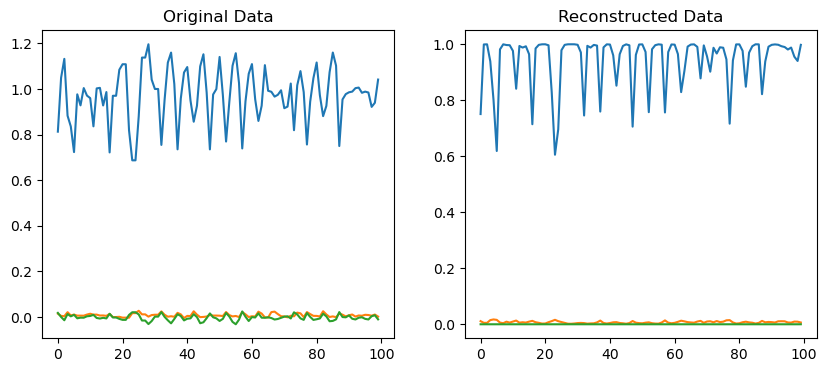

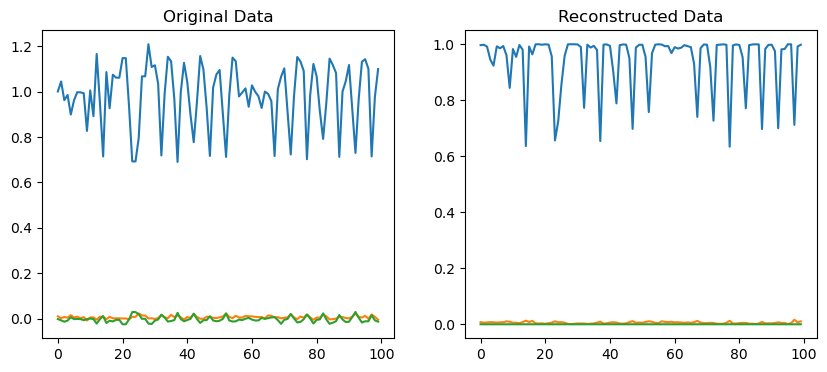

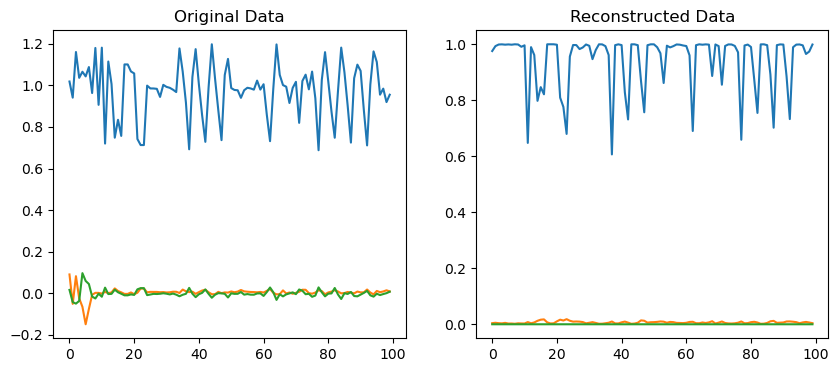

In [191]:
# x_test_injected_concat.shape
reconstructed_data = autoencoder.predict(x_test_injected_concat)

# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(10):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(x_test_injected_concat[-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()

In [120]:
# 비정상 데이터 확인
reconstructed_data = autoencoder.predict(all_anomaly_test_data[-1])

# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(10):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(all_anomaly_test_data[-1][-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()

NameError: name 'all_anomaly_test_data' is not defined

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


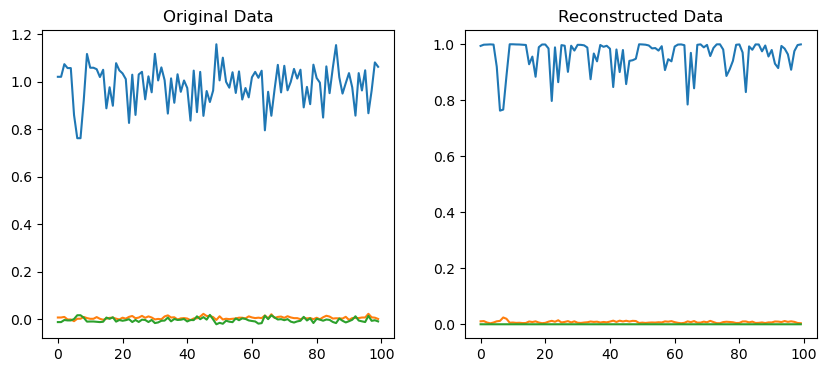

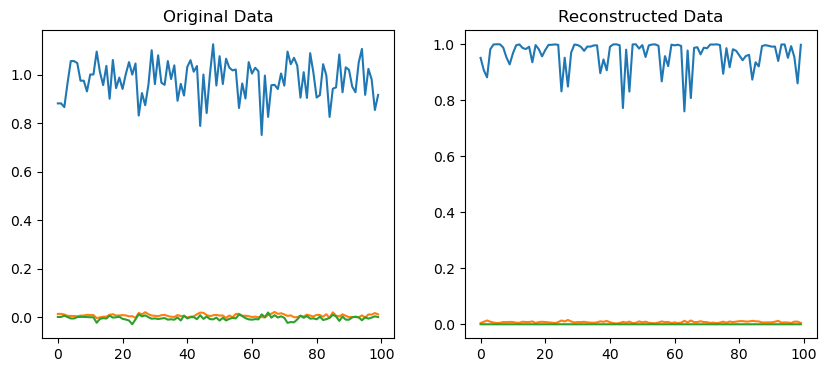

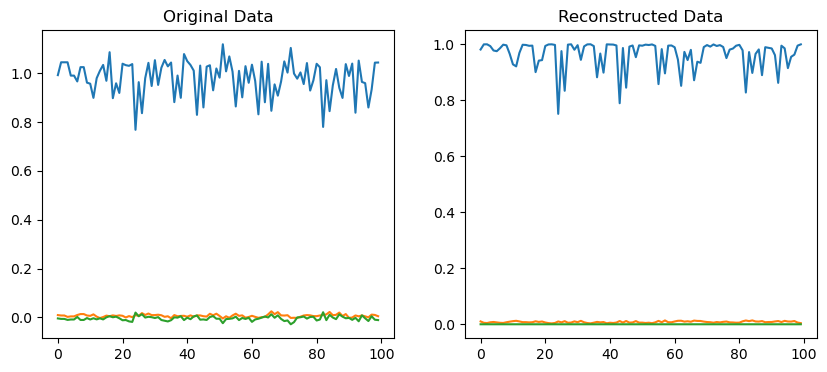

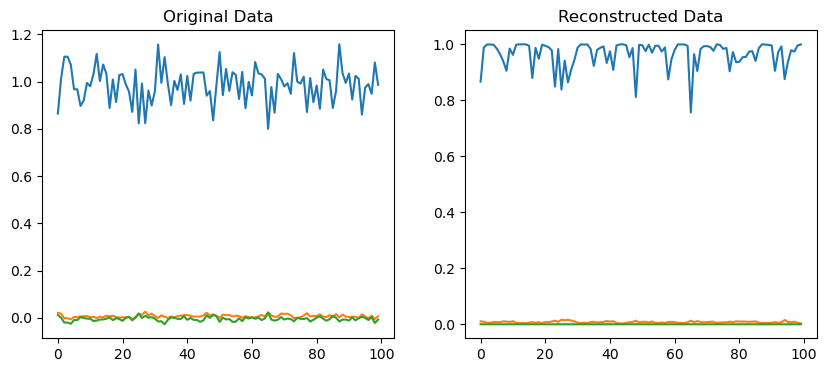

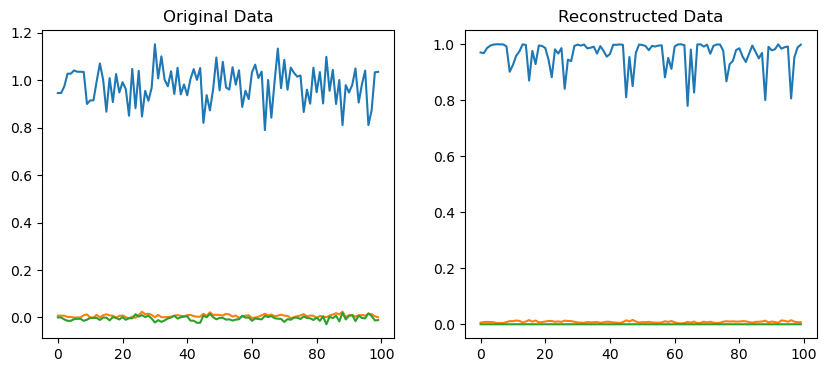

In [192]:
# 정상 데이터 확인
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)
# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(5):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(x_test_concat[i].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[i].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()

In [137]:
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)



print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
nan_count = np.sum(np.isnan(reconstruction_error)) 
reconstruction_error = np.nan_to_num(reconstruction_error)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)

print(mean_error, std_error)

# threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차

# mean_error = np.mean(reconstruction_error)
# std_error = np.std(reconstruction_error)
# threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차

threshold = np.percentile(reconstruction_error, 95) 
# print(threshold)
is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


# is_anomaly = reconstruction_error > threshold
is_anomaly = is_anomaly_x 

anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
False
0.004011439685653702 0.006675677825340763
어노말리 비율: 14.81%
정상 비율: 85.19%


(1081, 3)


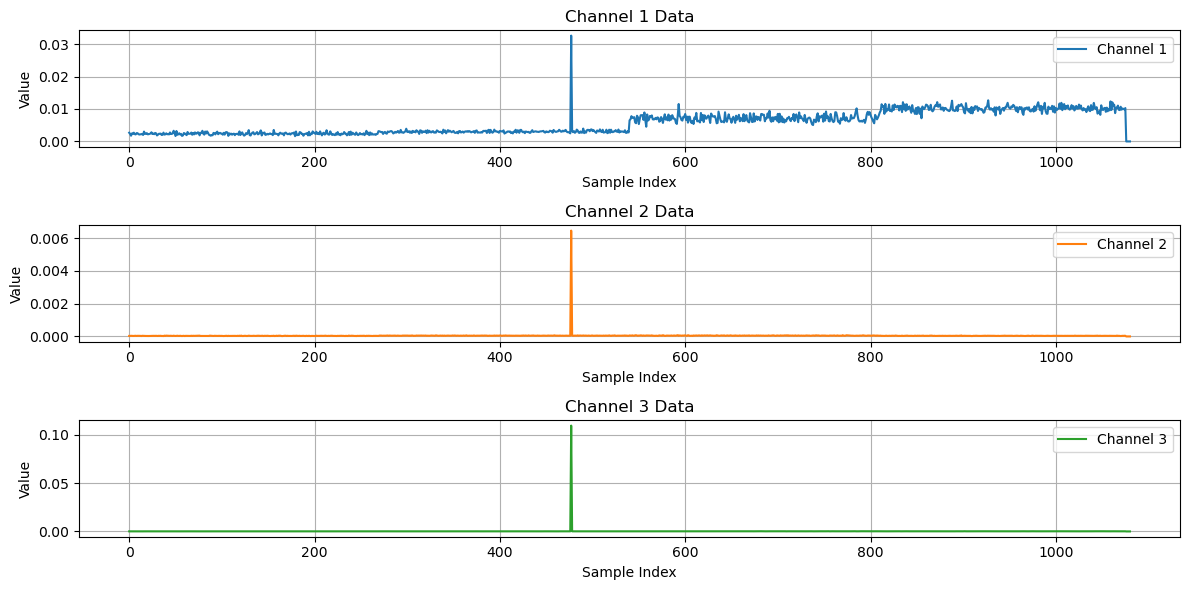

In [152]:
# 정상 데이터 reconstruction error
print(reconstruction_error.shape)

plt.figure(figsize=(12, 6))

# 각 채널에 대해 서브플롯 생성
for i in range(3):
    plt.subplot(3, 1, i + 1)  # 3행 1열의 서브플롯 설정
    plt.plot(reconstruction_error[:, i], label=f'Channel {i + 1}', color=f'C{i}')  # 채널별 그래프
    plt.title(f'Channel {i + 1} Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

In [77]:
reconstructed_data = autoencoder.predict(all_anomaly_test_data[-1])
reconstruction_error = np.mean(np.square(all_anomaly_test_data[-1] - reconstructed_data), axis=1)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
threshold = np.percentile(reconstruction_error, 70) 

is_anomaly = reconstruction_error > threshold
print(is_anomaly)

anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

[[False False False]
 [False False False]
 [False False False]
 ...
 [False False False]
 [False False False]
 [False False False]]
어노말리 비율: 0.00%
정상 비율: 100.00%


In [115]:
reconstructed_train_data = model.predict(x_train_concat)
reconstruction_error_train = np.mean(np.square(x_train_concat - reconstructed_train_data), axis=1)

threshold = np.percentile(reconstruction_error_train, 95)

print(threshold)

0.25549716585345333


0.0019767171913833816 0.0037745147912620815
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



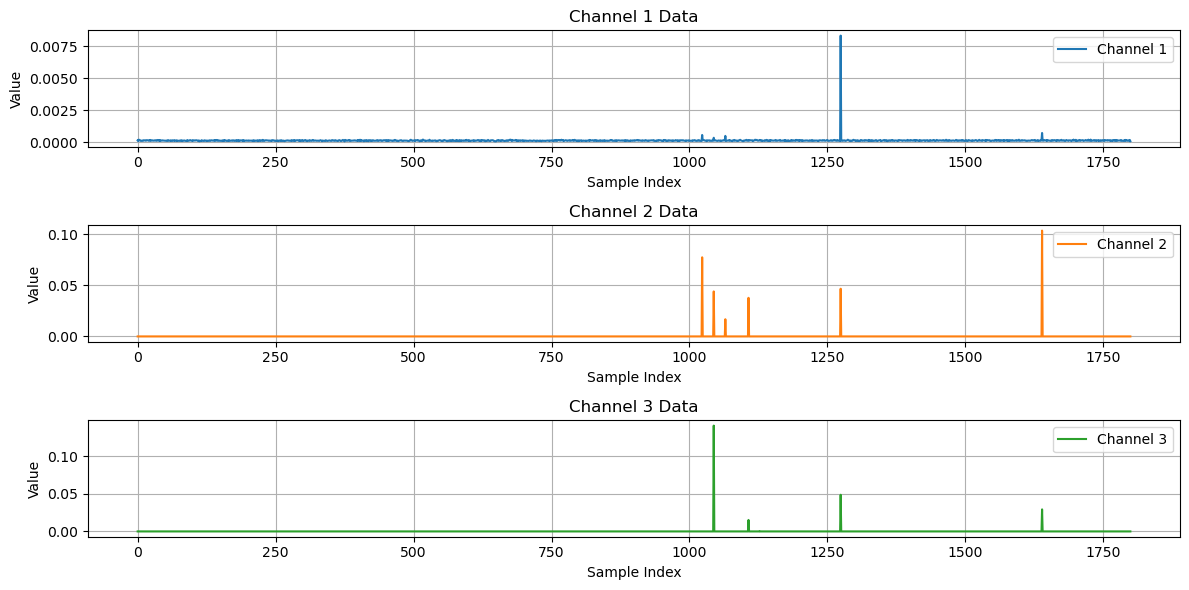

0.000161448694234028 0.0029117901939348643
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



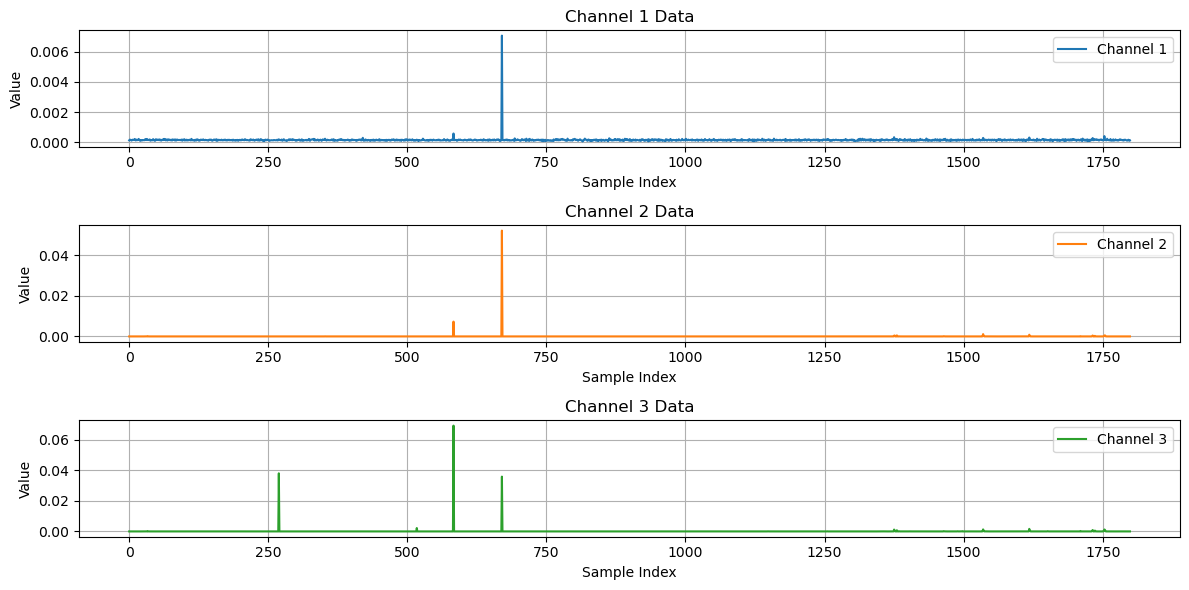

0.00010742630014032107 0.0013868686275227582
False
NaN의 개수: 0
어노말리 비율: 5.39%
정상 비율: 94.61%



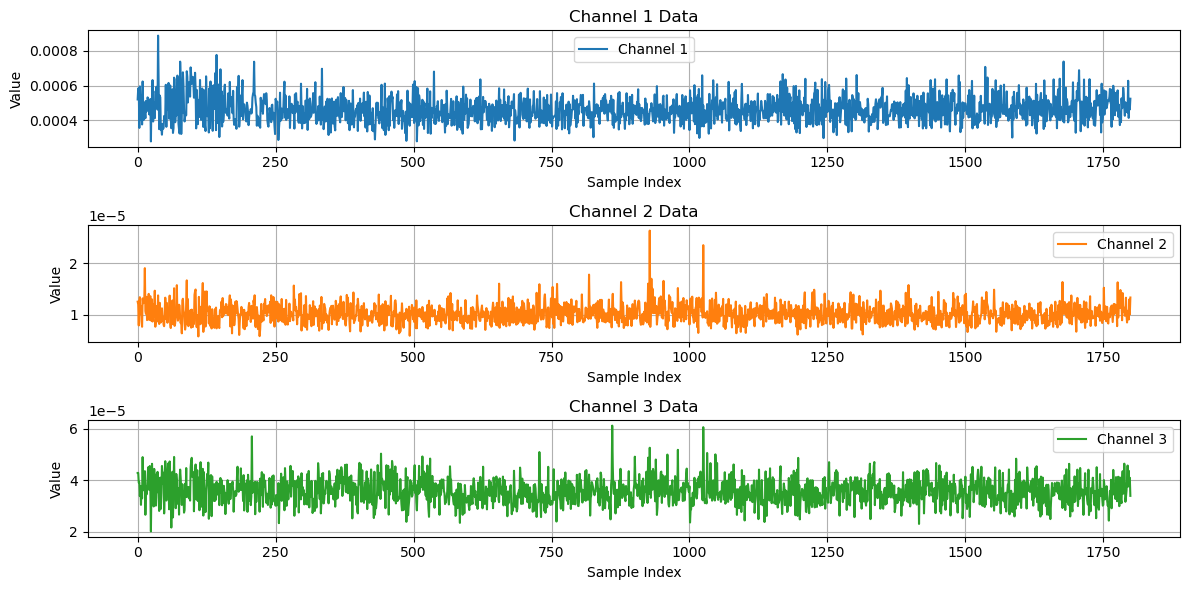

0.0001701271767217334 0.00021281645014890226
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



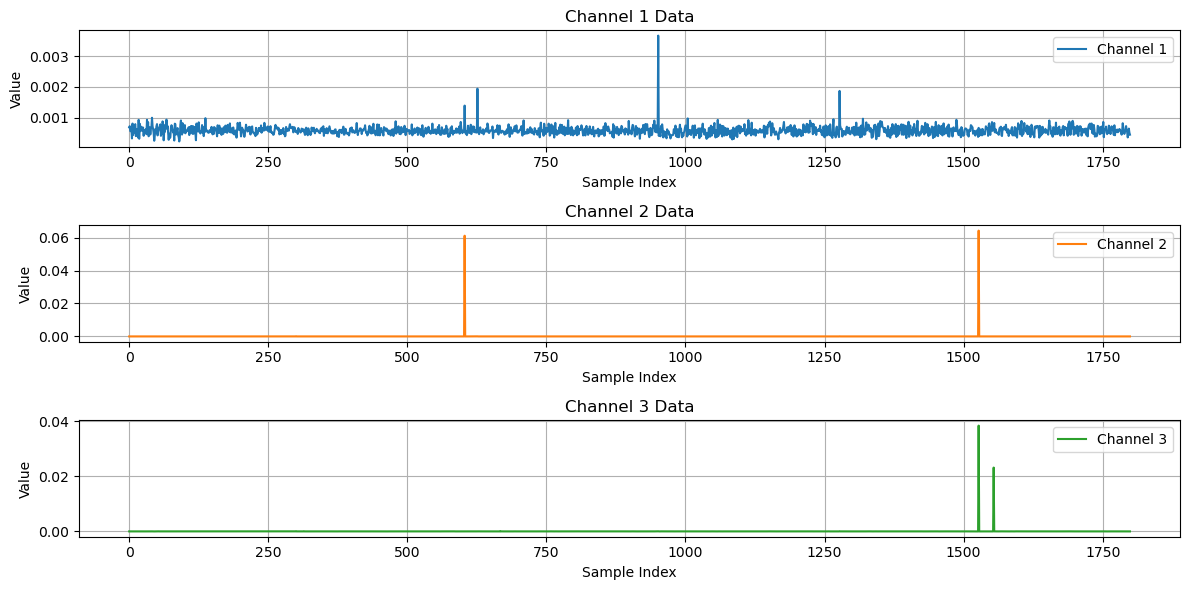

0.000240856847138468 0.0013754194911016848
False
NaN의 개수: 0
어노말리 비율: 0.11%
정상 비율: 99.89%



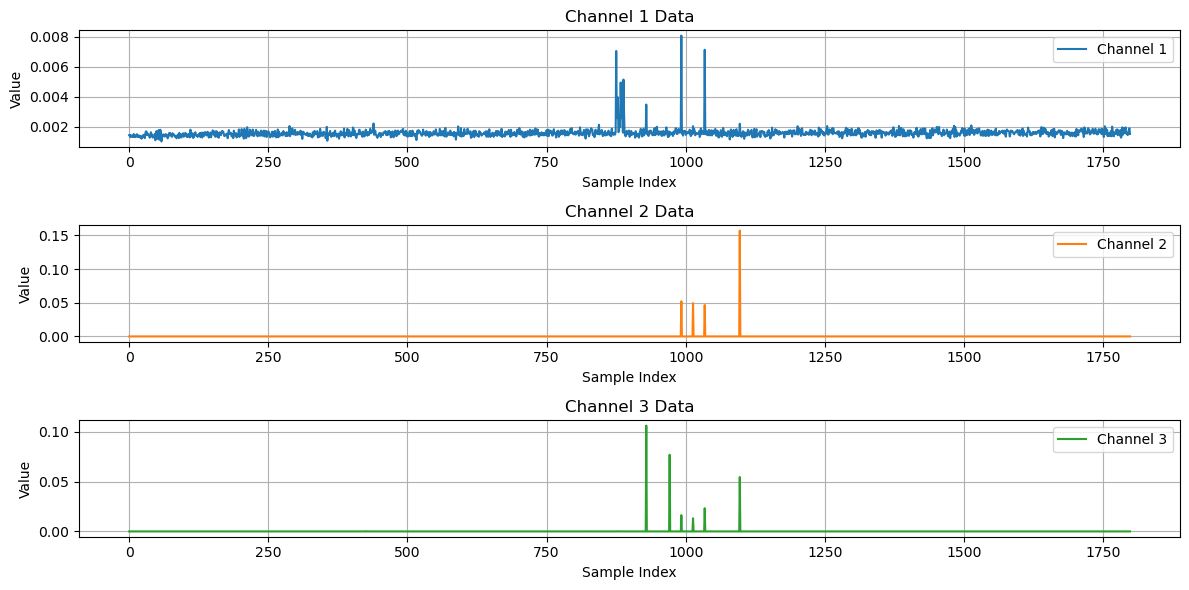

0.0006614669409380442 0.0032076350302301594
False
NaN의 개수: 0
어노말리 비율: 0.61%
정상 비율: 99.39%



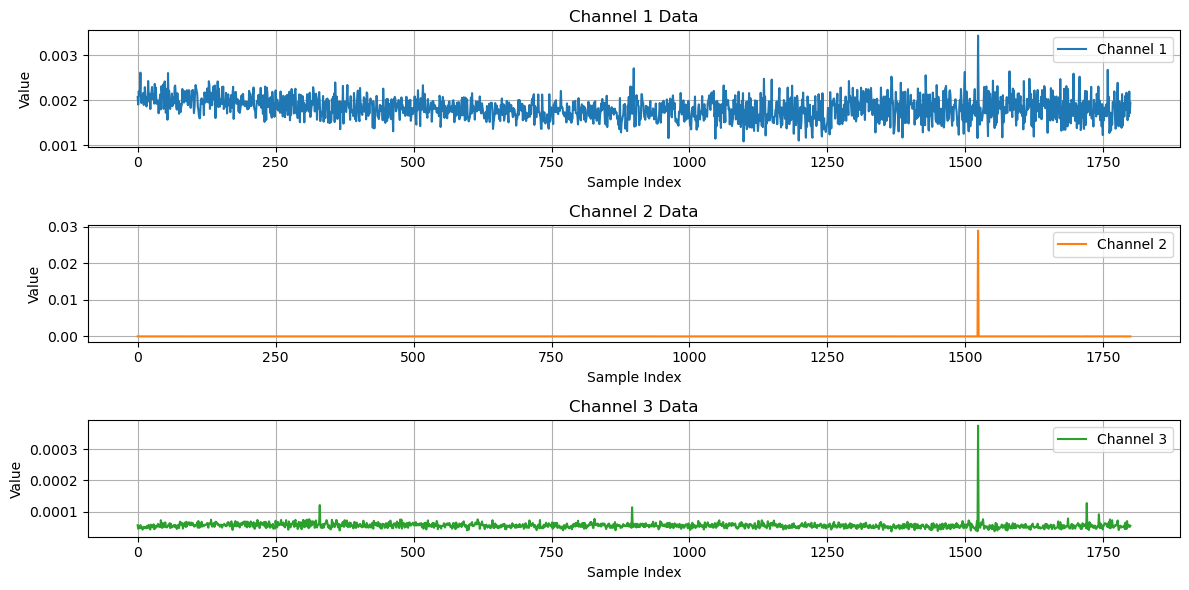

0.000637198982217752 0.0009395186665579832
False
NaN의 개수: 0
어노말리 비율: 10.17%
정상 비율: 89.83%



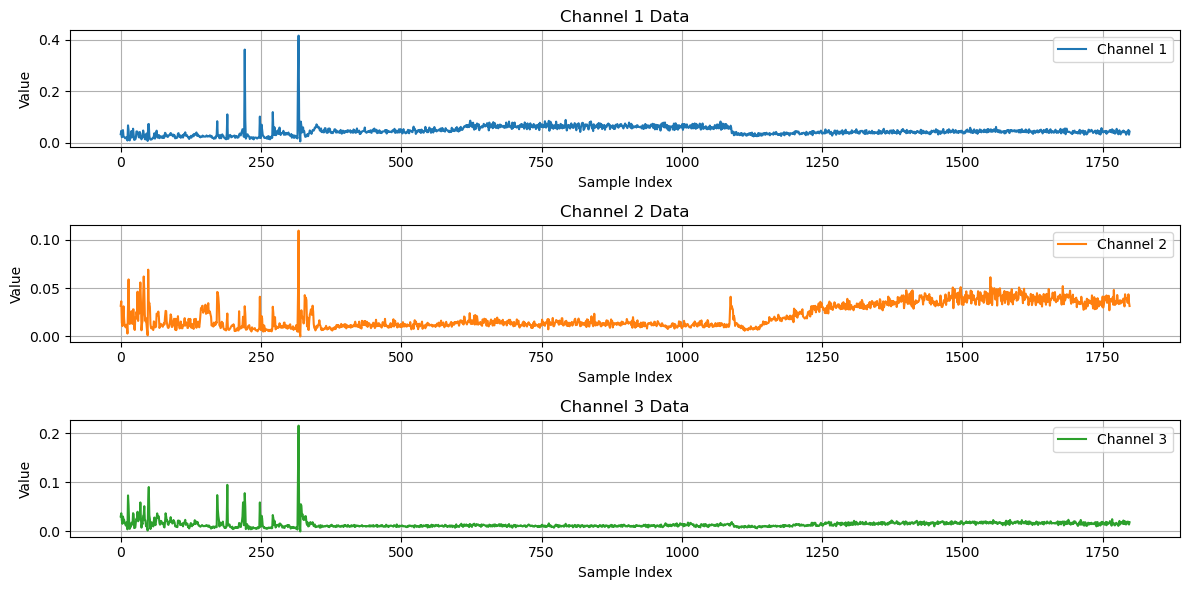

0.027127619396448255 0.019720200473028027
False
NaN의 개수: 0
어노말리 비율: 0.78%
정상 비율: 99.22%



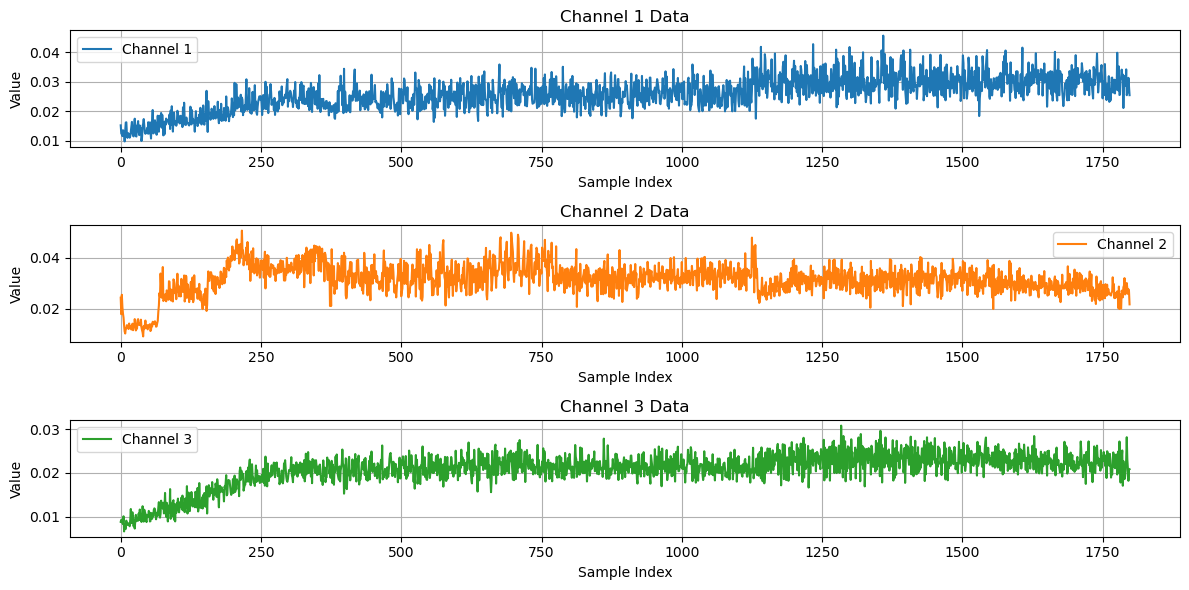

0.026088056287337666 0.006796761593673634
False
NaN의 개수: 0
어노말리 비율: 0.11%
정상 비율: 99.89%



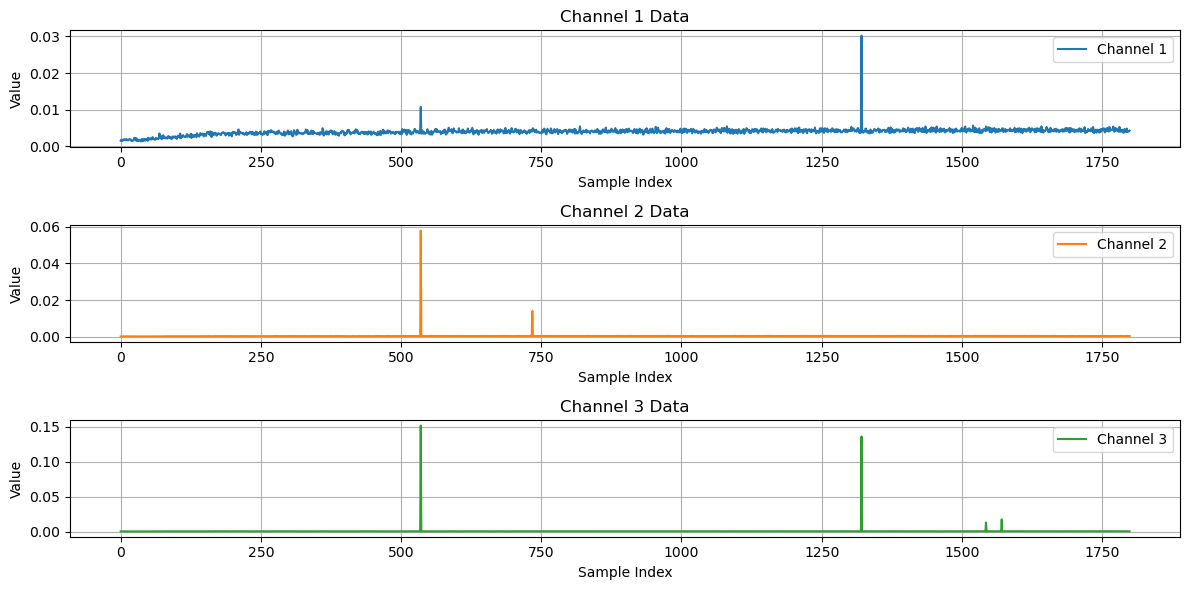

0.0015994445876588864 0.0033801256291500193
True
NaN의 개수: 3
어노말리 비율: 0.06%
정상 비율: 99.94%



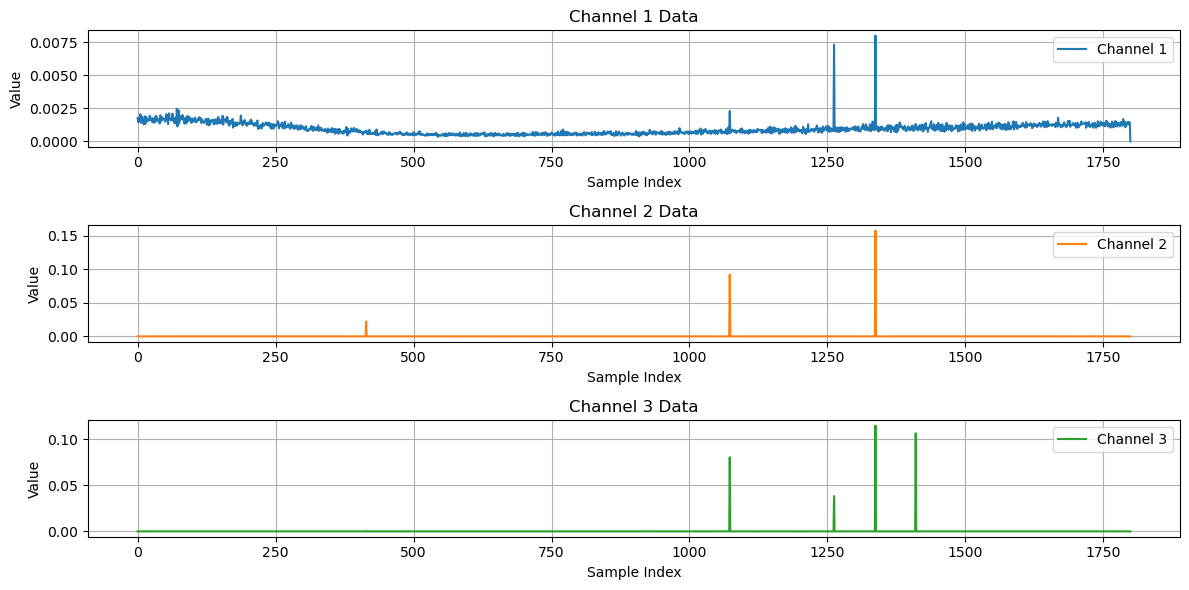

In [153]:
thresholds = []
for i in range(len(all_anomaly_test_data)):
    # print(all_anomaly_test_data[i].shape)
    # print(i)
    reconstructed_data = autoencoder.predict(all_anomaly_test_data[i])

    # print(reconstructed_data.shape)
    # print()
    reconstruction_error = np.mean(np.square(all_anomaly_test_data[i] - reconstructed_data), axis=1)
    # print(reconstruction_error.shape)
    # print()

    print(mean_error, std_error)
    print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
    nan_count = np.sum(np.isnan(reconstruction_error))  # NaN의 개수
    print(f'NaN의 개수: {nan_count}')
    reconstruction_error = np.nan_to_num(reconstruction_error)

    # threshold
    threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
    thresholds.append(threshold)

    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
    # print(threshold)
    is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
    is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
    is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축

    # 각 축 중 하나라도 True인 경우, 전체 데이터 포인트를 이상으로 판단
    # is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)
    is_anomaly = is_anomaly_x 

    # print(is_anomaly.shape) 

    # is_anomaly = reconstruction_error > threshold
    # print(is_anomaly.shape)

    # unique, counts = np.unique(is_anomaly, return_counts=True)
    # print(unique, counts)

    # # 결과 출력
    # anomaly_count = counts[1] if True in unique else 0  # True의 개수
    # normal_count = counts[0] if False in unique else 0  # False의 개수

    # print(f'어노말리 개수: {anomaly_count}')
    # print(f'정상 개수: {normal_count}')
    
    anomaly_count = np.sum(is_anomaly)  # True의 개수
    normal_count = len(is_anomaly) - anomaly_count  # False의 개수

    # # 비율 계산
    total_count = len(is_anomaly)
    anomaly_ratio = anomaly_count / total_count
    normal_ratio = normal_count / total_count

    print(f'어노말리 비율: {anomaly_ratio:.2%}')
    print(f'정상 비율: {normal_ratio:.2%}')

    # print()
    # print(len(is_anomaly), anomaly_count, normal_count, len(all_anomaly_test_data[i]))

    print()

    plt.figure(figsize=(12, 6))

    # 각 채널에 대해 서브플롯 생성
    for i in range(3):
        plt.subplot(3, 1, i + 1)  # 3행 1열의 서브플롯 설정
        plt.plot(reconstruction_error[:, i], label=f'Channel {i + 1}', color=f'C{i}')  # 채널별 그래프
        plt.title(f'Channel {i + 1} Data')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()

In [134]:
thresholds.sort()
thresholds

[3.832270737187668e-05,
 3.892730548185406e-05,
 4.2250423123683725e-05,
 4.767683198780388e-05,
 6.627507392953763e-05,
 6.721019841727373e-05,
 0.00010072665612422799,
 0.00042425265355872235,
 0.02995205702815639,
 0.03367608058045493]

In [123]:
threshold = thresholds[0]

In [128]:

for i in range(len(all_anomaly_test_data)):

    reconstructed_data = autoencoder.predict(all_anomaly_test_data[i])
    reconstruction_error = np.mean(np.square(all_anomaly_test_data[i] - reconstructed_data), axis=1)

    # nan 제거
    print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
    nan_count = np.sum(np.isnan(reconstruction_error))  # NaN의 개수
    reconstruction_error = np.nan_to_num(reconstruction_error)

    threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
    is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
    is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
    is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


    is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)

    
    anomaly_count = np.sum(is_anomaly)  # True의 개수
    normal_count = len(is_anomaly) - anomaly_count  # False의 개수

    # # 비율 계산
    total_count = len(is_anomaly)
    anomaly_ratio = anomaly_count / total_count
    normal_ratio = normal_count / total_count

    print(f'어노말리 비율: {anomaly_ratio:.2%}')
    print(f'정상 비율: {normal_ratio:.2%}')
    print()

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 84.21%
정상 비율: 15.79%

False
어노말리 비율: 78.43%
정상 비율: 21.57%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

True
어노말리 비율: 99.94%
정상 비율: 0.06%



In [138]:
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
# threshold = np.percentile(reconstruction_error, 95)  # 95번째 백분위수
is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)


anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
어노말리 비율: 22.50%
정상 비율: 77.50%


In [139]:
reconstructed_data = autoencoder.predict(x_test_injected_concat)
reconstruction_error = np.mean(np.square(x_test_injected_concat - reconstructed_data), axis=1)
threshold = np.percentile(reconstruction_error, 95)  # 95번째 백분위수
mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)


anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
어노말리 비율: 18.33%
정상 비율: 81.67%
